# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Returns of securities around FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerPatch

from FOMCDataPrep import DataPrep
from sklearn.decomposition import PCA

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

First look at the return of Treasury Futures around FOMC announcement

In [21]:
def _get_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            PX_diff = lambda x: x.PX_LAST.diff(),
            bps = lambda x: x.PX_diff / x.duration))

def get_tsy_bps() -> pd.DataFrame: 

    data_prep = DataPrep()

    df_tsy = data_prep.get_fut_data()
    df_deliv = data_prep.get_bond_deliverables()

    df_duration = (df_deliv.query(
        "variable == 'CONVENTIONAL_CTD_FORWARD_FRSK'").
        drop(columns = ["variable"]).
        rename(columns = {"value": "duration"}))


    df_out = (df_tsy.merge(
        right = df_duration, how = "inner", on = ["date", "security"]).
        groupby("security").
        apply(_get_bps))
    
    return df_out

def prep_nlp() -> pd.DataFrame: 
    
    df_nlp = (DataPrep().get_labor_sentiment().reset_index().assign(
        date = lambda x: pd.to_datetime(x.date).dt.date))
    
    return df_nlp

df_nlp = prep_nlp()
df_tsy_bps = get_tsy_bps()

Searching for Labor Data
Found Data

Searching for Futures Data
Found Data

Searching for Bond Future Deliverables
Found Data



In [4]:
def _get_order(df: pd.DataFrame, before: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        reset_index(drop = True).
        reset_index().
        rename(columns = {"index": "day"}).
        assign(day = lambda x: x.day + before))
    
    return df_out

def get_order_bps(df_tsy_bps: pd.DataFrame, before: float = -6, after: float = 2) -> pd.DataFrame: 

    min_date = df_tsy_bps.date.min().date()

    df_dates = (BBGCollect()._get_days_window(
        ticker = "FDTR", before = before, after = after).
        query("start_date >= @min_date").
        reset_index(drop = True))

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row

        df_tmp = (df_tsy_bps.query(
            "@start_date <= date <= @end_date").
            groupby("security").
            apply(_get_order, before).
            assign(event = i + 1).
            reset_index(drop = True))

        df_combined = pd.concat([df_combined, df_tmp])
        
    return df_combined

df_bps_event = get_order_bps(df_tsy_bps)

In [5]:
def get_cum_bps(df_bps_event: pd.DataFrame) -> pd.DataFrame: 
    
    df_cum_bps = (df_bps_event[
        ["day", "security", "bps"]].
        groupby(["day", "security"]).
        agg("mean").
        reset_index().
        assign(security = lambda x: x.security.str.split(" ").str[0].str.replace("1", "")).
        query("day != 4").
        pivot(index = "day", columns = "security", values = "bps").
        cumsum())
    
    return df_cum_bps

df_cum_bps = get_cum_bps(df_bps_event)

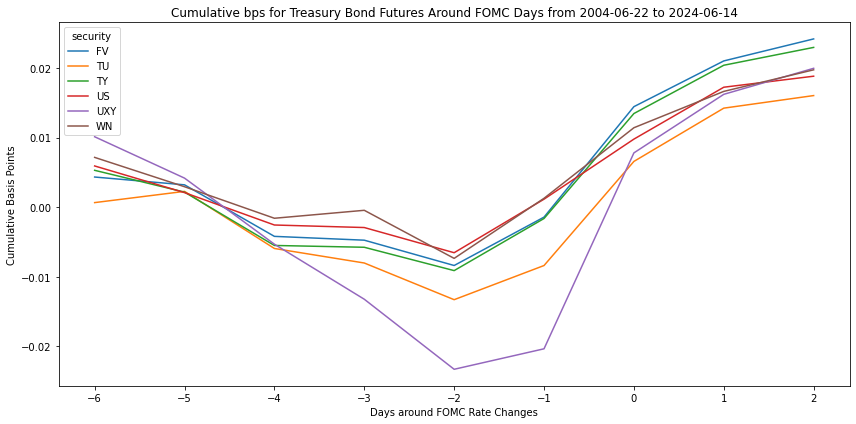

In [6]:
def plot_cumulative_bps(df_cum_bps: pd.DataFrame) -> plt.Figure:
    
    (df_cum_bps.plot(
        figsize = (12,6),
        ylabel = "Cumulative Basis Points",
        xlabel = "Days around FOMC Rate Changes",
        title = "Cumulative bps for Treasury Bond Futures Around FOMC Days from {} to {}".format(
            df_bps_event.date.min().date(),
            df_bps_event.date.max().date())))

    plt.tight_layout()
    
plot_cumulative_bps(df_cum_bps)

## Returns conditioned on Fed Event

In [7]:
def _fill_rate_event(df: pd.DataFrame) -> pd.DataFrame: 
    
    vals = df.fed_rate_diff.drop_duplicates().to_list()
    vals.remove(0)
    
    if len(vals) == 0: input_val = 0
    else: input_val = vals[0]
    
    if input_val == 0: event_type = "no_change"
    elif input_val > 0: event_type = "hike"
    else: event_type = "cut"
    
    df_out = (df.assign(
        fed_rate_diff = input_val,
        event = event_type))
    
    return df_out

def get_fed_data(df_bps_event: pd.DataFrame) -> pd.DataFrame: 

    data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data", "FedFundsRate.parquet")

    df_fed = (pd.read_parquet(
        path = data_path, engine = "pyarrow").
        sort_values("date").
        rename(columns = {"value": "fed_rate"}).
        drop(columns = ["security"]).
        assign(
            date = lambda x: pd.to_datetime(x.date).dt.date,
            fed_rate_diff = lambda x: x.fed_rate.diff()))

    df_out = (df_bps_event.assign(
        date = lambda x: pd.to_datetime(x.date).dt.date).
        merge(right = df_fed, how = "inner", on = ["date"]).
        groupby("event").
        apply(_fill_rate_event).
        reset_index(drop = True))
    
    return df_out

df_fed_event = get_fed_data(df_bps_event)

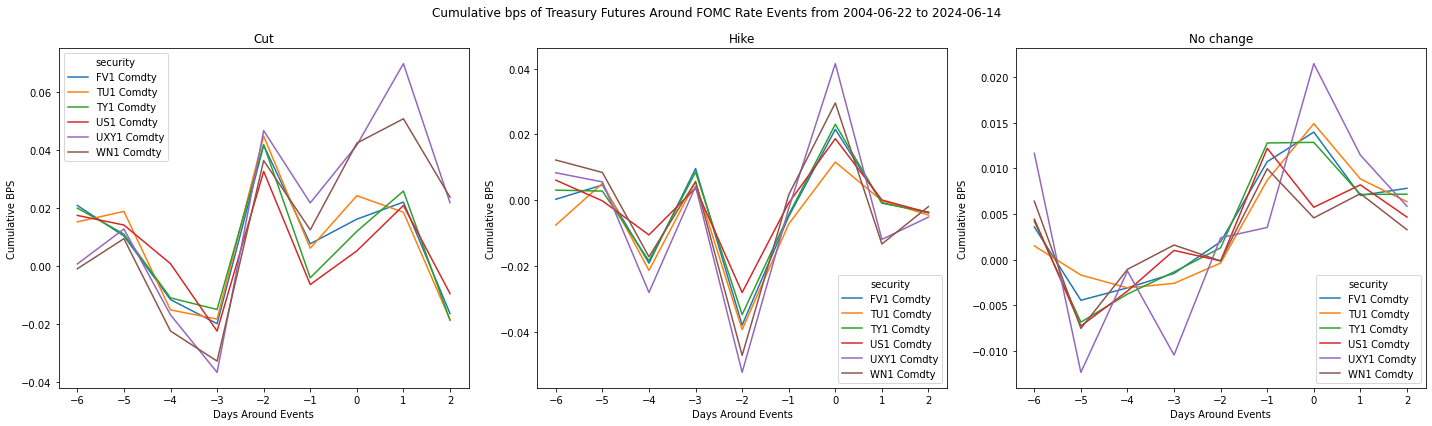

In [74]:
def plot_cumulative_bps(df_fed_event: pd.DataFrame, df_bps_event: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_fed_event[
        ["day", "bps", "event", "security"]].
        groupby(["day", "security", "event"]).
        agg("mean").
        reset_index().
        assign(event = lambda x: x.event.str.replace("_", " ").str.capitalize()))

    events = df_tmp.event.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(events), figsize = (20,6))

    for event, ax in zip(events, axes.flatten()):

        (df_tmp.query(
            "event == @event").
            drop(columns = ["event"]).
            pivot(index = "day", columns = "security", values = "bps").
            plot(
                ax = ax,
                ylabel = "Cumulative BPS",
                xlabel = "Days Around Events",
                title = event))

    fig.suptitle("Cumulative bps of Treasury Futures Around FOMC Rate Events from {} to {}".format(
        df_bps_event.date.min().date(),
        df_bps_event.date.max().date()))

    plt.tight_layout()
    
plot_cumulative_bps(df_fed_event, df_bps_event)

## Returns conditioned on Labor Sentiment

We'll condition returns on the 3rd day before the Fed Hike

In [61]:
def _fill_benlpfed(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.sort_values(
        "BENLPFED").
        assign(BENLPFED = lambda x: x.BENLPFED.fillna(method = "ffill")))
    
    return df_out

def fill_benlpfed(df_nlp: pd.DataFrame, df_bps_event: pd.DataFrame) -> pd.DataFrame: 

    slice_date = df_nlp.date.min()

    df_bps_tmp = (df_bps_event.assign(
        date = lambda x: pd.to_datetime(x.date).dt.date).
        query("date >= @slice_date"))

    df_out = (df_bps_tmp.query(
        "day == -3")
        [["date"]].
        groupby("date").
        first().
        reset_index().
        merge(right = df_nlp, how = "inner", on = ["date"]).
        merge(right = df_bps_tmp, how = "outer", on = ["date"]).
        groupby("event").
        apply(_fill_benlpfed).
        reset_index(drop = True).
        assign(labor_sentiment = lambda x: np.where(
            x.BENLPFED > 0, 
            "pos", 
            "neg")))
    
    return df_out

df_fill_benlp = fill_benlpfed(df_nlp, df_bps_event)

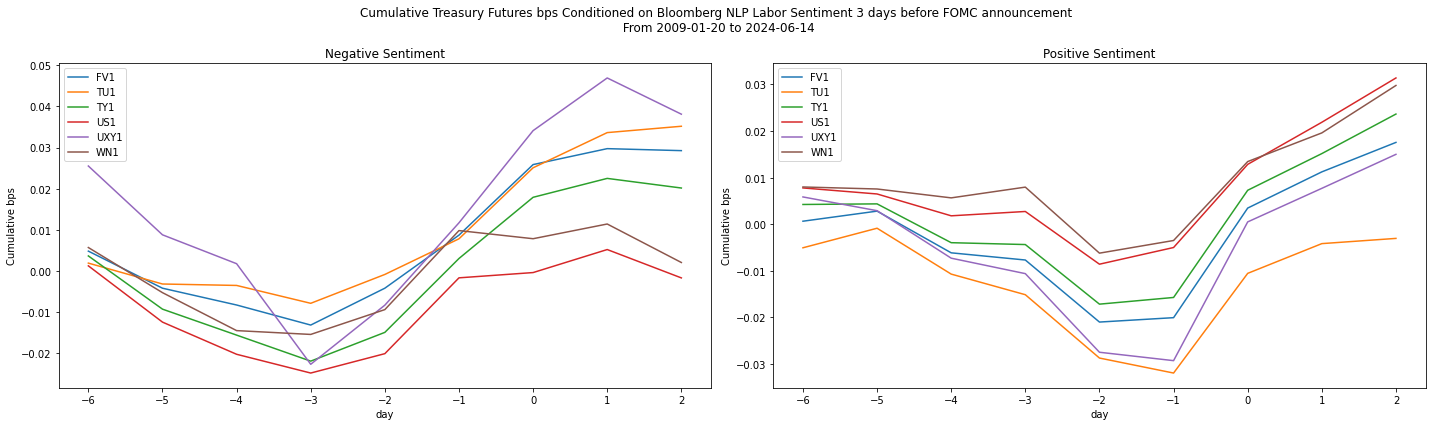

In [75]:
def cumulative_sentiment_bps(df_fill_benlp: pd.DataFrame) -> pd.DataFrame: 
    
    sentiment_dict = {
        "neg": "Negative Sentiment",
        "pos": "Positive Sentiment"}

    fig, axes = plt.subplots(ncols = len(sentiment_dict.keys()), figsize = (20,6))

    df_plot = (df_fill_benlp[
        ["day", "security", "bps", "labor_sentiment"]].
        groupby(["labor_sentiment", "day", "security"]).
        agg("mean").
        reset_index().
        assign(security = lambda x: x.security.str.split(" ").str[0]))

    for sentiment, ax in zip(sentiment_dict.keys(), axes.flatten()):

        (df_plot.query(
            "labor_sentiment == @sentiment").
            drop(columns = ["labor_sentiment"]).
            pivot(index = "day", columns = "security", values = "bps").
            cumsum().
            plot(
                ax = ax,
                ylabel = "Cumulative bps",
                title = sentiment_dict[sentiment]))

        ax.legend(loc = "upper left")

    fig.suptitle("Cumulative Treasury Futures bps Conditioned on Bloomberg NLP Labor Sentiment 3 days before FOMC announcement\n From {} to {}".format(
        df_fill_benlp.date.min(),
        df_fill_benlp.date.max()))
    
    plt.tight_layout()
    
cumulative_sentiment_bps(df_fill_benlp)

## Conditional Returns on Sentiment and Rate Change

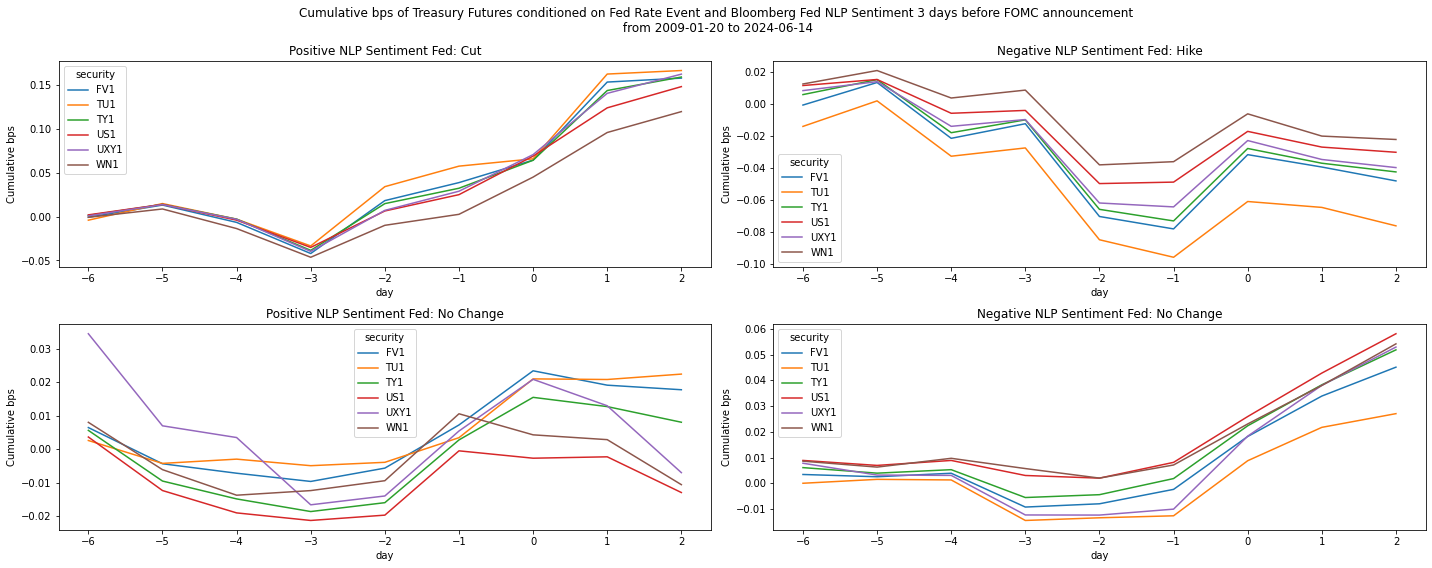

In [139]:
def plot_fed_nlp_conditioned_returns(df_fed_event: pd.DataFrame, df_fill_benlp: pd.DataFrame) -> pd.DataFrame: 

    df_tmp = (df_fed_event[
        ["day", "date", "event"]].
        rename(columns = {"event": "fed_event"}).
        merge(right = df_fill_benlp, how = "inner", on = ["day", "date"]).
        assign(group_var = lambda x: x.fed_event + " " + x.labor_sentiment)
        [["group_var", "day", "security", "bps"]].
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        groupby(["group_var", "day", "security"]).
        agg("mean").
        reset_index())

    events = df_tmp.group_var.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(events) // 2, nrows = len(events) // 2, figsize = (20,8))

    sentiment_renamer = {
        "neg": "Positive NLP Sentiment",
        "pos": "Negative NLP Sentiment"}

    fed_event_renamer = {
        "cut": "Fed: Cut",
        "hike": "Fed: Hike",
        "no_change": "Fed: No Change"}

    for event, ax in zip(events, axes.flatten()):

        fed_event, sentiment = event.split(" ")

        (df_tmp.query(
            "group_var == @event").
            drop(columns = ["group_var"]).
            pivot(index = "day", columns = "security", values = "bps").
            cumsum().
            plot(
                ylabel = "Cumulative bps",
                ax = ax,
                title = sentiment_renamer[sentiment] + " " + fed_event_renamer[fed_event]))

    fig.suptitle("Cumulative bps of Treasury Futures conditioned on Fed Rate Event and Bloomberg Fed NLP Sentiment 3 days before FOMC announcement\n from {} to {}".format(
        df_fill_benlp.date.min(),
        df_fill_benlp.date.max()))

    plt.tight_layout()
    
plot_fed_nlp_conditioned_returns(df_fed_event, df_fill_benlp)

## Buy Treasuries 4 days before and sell them 1 day before FOMC Day

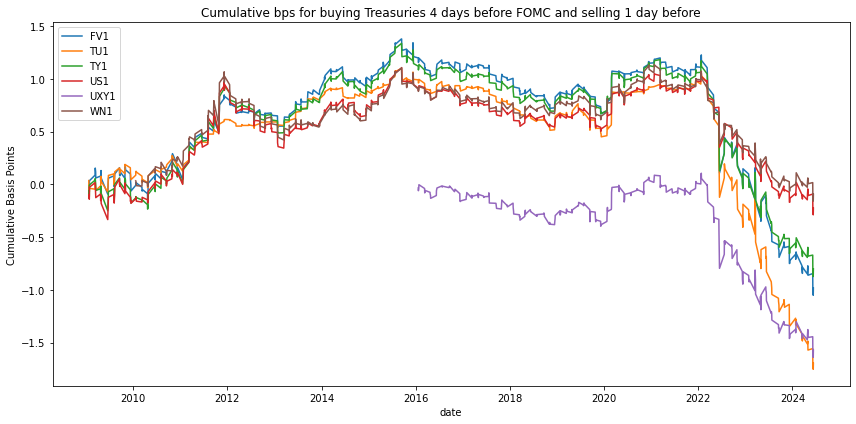

In [146]:
def plot_naive_treasury_returns(df_fill_benlp: pd.DataFrame) -> plt.Figure: 
    
    _, axes = plt.subplots(figsize = (12,6))

    (df_fill_benlp.query(
        "-4 <= day <= -1")
        [["date", "security", "bps"]].
        drop_duplicates().
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        pivot(index = "date", columns = "security", values = "bps").
        cumsum().
        plot(
            ax = axes,
            title = "Cumulative bps for buying Treasuries 4 days before FOMC and selling 1 day before",
            ylabel = "Cumulative Basis Points"))

    axes.legend(loc = "upper left")
    plt.tight_layout()
    
plot_naive_treasury_returns(df_fill_benlp)

The performance has two problems one which is evident and the other which may be more naunced
1. The drop off in performance after 2022 
2. The lack of pre 2009 which only captures one regime of the Fed

The second problem can't be fixed unfortunately. The dropoff of performance comes from the signal being too naive since it always buys Treasuries. Putting aside the lookahead bias first start with conditioning the positioning by using the federal sentiment of 5 days before the fed event for the same window.

In [173]:
(df_fill_benlp[
    ["date", "day", "event"]].
    query("day == -5").
    merge(right = df_nlp, how = "inner", on = ["date"]).
    assign())

,date,day,event,BENLPFED
0,2009-01-21,-5,40,-2.09
1,2009-01-21,-5,40,-2.09
2,2009-01-21,-5,40,-2.09
3,2009-01-21,-5,40,-2.09
4,2009-03-11,-5,41,-6.60
...,...,...,...,...
681,2024-06-05,-5,164,5.38
682,2024-06-05,-5,164,5.38
683,2024-06-05,-5,164,5.38
684,2024-06-05,-5,164,5.38
